In [3]:
import os
import sys
import glob

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as colors
import pandas as pd
import geopandas as gpd
import xarray as xr
import datetime
import itertools
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

from scipy import stats


In [4]:
# date and end datatime for the analises in this notebook

start_datetime = pd.to_datetime('20190720')
end_datetime = pd.to_datetime('20190801')

print(f'start_datetime: {start_datetime}')
print(f'end_datetime: {end_datetime}')


start_datetime: 2019-07-20 00:00:00
end_datetime: 2019-08-01 00:00:00


In [5]:
# list Harm files for the selected date
path_Harm_grib = './Harmonie_GRIB_July_2019/'
# Harm_filenames = sorted(glob.glob(os.path.join(path_Harm_grib,'HA40_N25_000_20190730*_GB')))
# Harm_filenames = sorted(glob.glob(os.path.join(path_Harm_grib,f'HA40_N25_000_{sta_date:%Y%m%d}*_GB')))


Harm_filenames_all = np.array(sorted(glob.glob(os.path.join(path_Harm_grib,'HA40_N25_*_GB'))))
Harm_filenames_all

Harm_filenames_all_dt = datenum_aux = pd.to_datetime(
    np.unique([glob.re.findall("_(\d{8}0000_0\d{4})", f)[0] for f in Harm_filenames_all]),
    format='%Y%m%d0000_0%H%M',
)

# files from the selected time interval [start_datetime, end_datetime[
Harm_filenames = list(Harm_filenames_all[(Harm_filenames_all_dt >= start_datetime) & (Harm_filenames_all_dt < end_datetime)])
Harm_filenames[0:10]

['./Harmonie_GRIB_July_2019/HA40_N25_000_201907200000_00000_GB',
 './Harmonie_GRIB_July_2019/HA40_N25_000_201907200000_00100_GB',
 './Harmonie_GRIB_July_2019/HA40_N25_000_201907200000_00200_GB',
 './Harmonie_GRIB_July_2019/HA40_N25_000_201907200000_00300_GB',
 './Harmonie_GRIB_July_2019/HA40_N25_000_201907200000_00400_GB',
 './Harmonie_GRIB_July_2019/HA40_N25_000_201907200000_00500_GB',
 './Harmonie_GRIB_July_2019/HA40_N25_000_201907200000_00600_GB',
 './Harmonie_GRIB_July_2019/HA40_N25_000_201907200000_00700_GB',
 './Harmonie_GRIB_July_2019/HA40_N25_000_201907200000_00800_GB',
 './Harmonie_GRIB_July_2019/HA40_N25_000_201907200000_00900_GB']

In [6]:
def open_harmonie_as_xr(filenames_list):
    
    kwargs_dic = {'filter_by_keys': {'typeOfLevel': 'heightAboveGround', 'level': 2, 'stepType': 'instant', 'indicatorOfParameter': 11}}
    
    ds_list = []
    for file in filenames_list:
        
        ds_list.append(xr.open_dataset(file, engine='cfgrib', backend_kwargs=kwargs_dic).expand_dims({'valid_time':1}))
    return xr.concat(ds_list,dim='valid_time').rename_vars(unknown='t2m_k')
    

 

In [7]:
harm_ds = open_harmonie_as_xr(Harm_filenames)

# harm_ds

ValueError: unrecognized engine cfgrib must be one of: ['netcdf4', 'scipy', 'store']

In [38]:
path_in_wow = r"/home/jovyan/work/aggregations/{0}"
file_template = r"{0}aggregation_60min.csv"

sta_date = start_datetime
end_date = end_datetime

time_range_days = pd.date_range(start=sta_date, end=end_date, freq="D")

df_60m_temp = pd.DataFrame()
for date in time_range_days:
    cur_file = file_template.format(date.strftime("%Y-%m-%d"))
    cur_path = path_in_wow.format(cur_file)
    df = pd.read_csv(cur_path, sep=",", header=[0, 1], index_col=[0, 1, 2])
    df = df["DryBulbTemperature_Celsius"] # Now columns are: ['Latitude', 'Longitude', 'CreatedDateTime', 'mean', 'min', 'max']
    df = df.reset_index(inplace=False)
    df.CreatedDateTime = pd.to_datetime(df.CreatedDateTime)
    df.CreatedDateTime.astype('datetime64[ns]')
    df_60m_temp = pd.concat([df_60m_temp, df], axis=0)
    
# df_60m_temp  

In [39]:
# HARMONIE: Read all hourly aggregations for the heatwave period

import shutup; shutup.please()

def dates_like_this(x):
    try: 
        datefromstr = pd.to_datetime(pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
    except ValueError as e: 
        # Patching midnights, because reasons....
        datefromstr = pd.datetime.strptime(x, "%Y-%m-%d")
        datefromstr = pd.to_datetime(datefromstr.replace(minute=0, hour=0, second=1))
    return datefromstr

path_in_harm = r"/home/jovyan/work/Harmonie_values_at_WOW_locations/{0}.csv"

time_range_hours = pd.date_range(start=sta_date, end=end_date, freq="H")[:-24]

df_60m_harm = pd.DataFrame()
for date in time_range_hours:
    date_str = date.strftime("%Y-%m-%d %H:%M")
    cur_path = path_in_harm.format(date_str)
    df = pd.read_csv(cur_path, sep=",", header=0, index_col=0, parse_dates=["datetime"], date_parser=dates_like_this) 
    df_60m_harm = pd.concat([df_60m_harm, df], axis=0)  
    df_60m_harm["t2m_c"] = df_60m_harm["t2m_k"] - 273.15
# df_60m_harm


2019-07-20 00:00:00 -0.158 1.029
2019-07-21 00:00:00 0.115 1.098
2019-07-22 00:00:00 0.722 1.457
2019-07-23 00:00:00 0.686 1.675
2019-07-24 00:00:00 -0.31 1.665
2019-07-25 00:00:00 0.047 1.58
2019-07-26 00:00:00 0.112 1.655
2019-07-27 00:00:00 -0.294 1.233
2019-07-28 00:00:00 0.002 0.975
2019-07-29 00:00:00 0.848 1.002


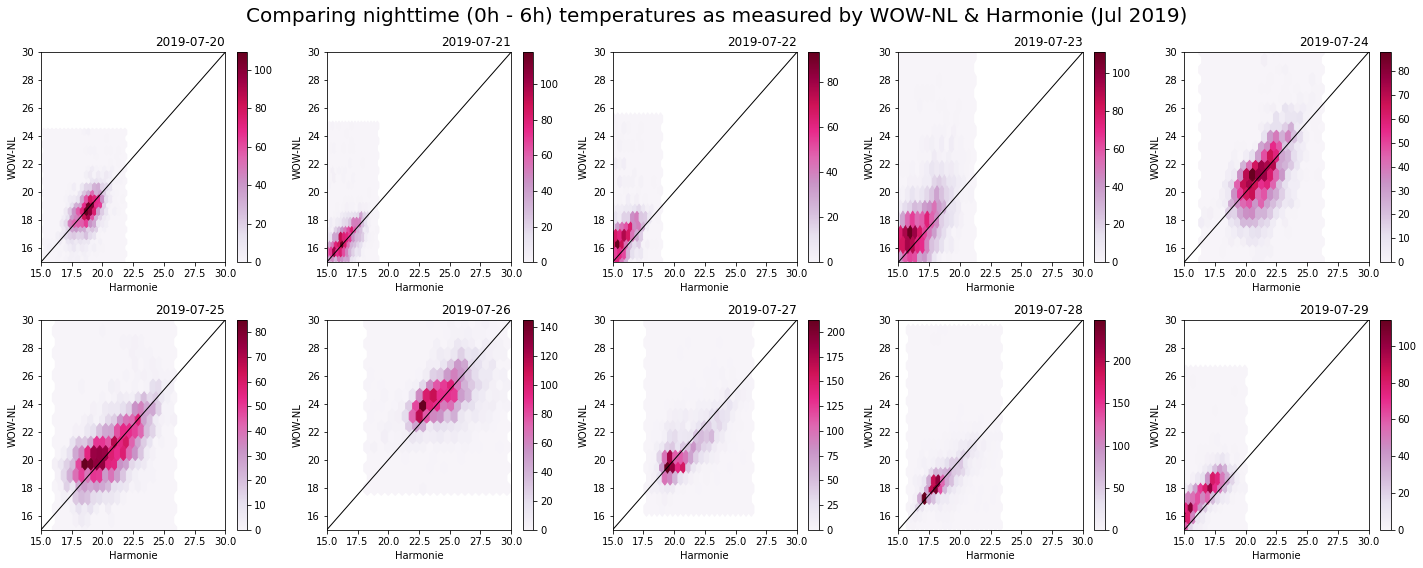

In [167]:

# Just in case we recast to 'datetime64[ns]'
df_60m_harm.datetime.astype('datetime64[ns]')
df_60m_temp.CreatedDateTime.astype('datetime64[ns]')

# Merging Harmonie and WOW dataframes, then selecting only the nighttime
# temperatures and grouping per day to create the multiple miniplots
df_merged = pd.merge(df_60m_harm, df_60m_temp, how="left", left_on=["latitude", "longitude", "datetime"], right_on=["Latitude", "Longitude", "CreatedDateTime"])
df_merged = df_merged.set_index(pd.DatetimeIndex(df_merged['datetime']))
df_selected = df_merged.between_time('00:00', '06:00')
df_grouped = df_selected.groupby(pd.Grouper(key="datetime", freq="D"))

# Prepare plot
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
plt.suptitle("Comparing nighttime (0h - 6h) temperatures as measured by WOW-NL & Harmonie (Jul 2019)", size=20)
plt.subplots_adjust(hspace=0.5, wspace=0.5)
# plt.xlabel("Harmonie's deterministic forecast")
# plt.ylabel("WOW-NL observations")

# fig.text(0.5, 0.04, 'Harmonie\'s deterministic forecast', ha='center')

rows = range(0, 2)
cols = range(0, 5)
pairs = list(itertools.product(rows, cols))

i = 0
for name, group in df_grouped:
    if i == 10:
        break
    
    data_wow = group["mean"]
    data_har = group["t2m_c"]    
    
    r, c = pairs[i]
    ax[r, c].set_title(str(name).split(" ")[0], loc='right') #, fontweight="bold")
    ax[r, c].set_xlim(15, 30)
    ax[r, c].set_ylim(15, 30)
    ax[r, c].plot([15, 30], [15, 30], 'black', linewidth=1)
    ax[r, c].set_xlabel("Harmonie")
    ax[r, c].set_ylabel("WOW-NL")
    bar = ax[r, c].hexbin(data_har, data_wow, gridsize = 20, cmap=plt.cm.PuRd)
    cb = fig.colorbar(bar, ax=ax[r,c])
    
    bias = np.mean(data_wow - data_har)
    noise = np.std(data_wow - data_har)
    
    print(name, np.round(bias, decimals=3), np.round(noise, decimals=3))
    
    i += 1 
    
plt.tight_layout()

# plt.savefig('./figures_diego/harm_vs_wow_irene_hexabin.png')
plt.show()


In [43]:
gdf_NL = gpd.read_file(
    filename="./NL_shapefile_irene/NL_WGS84.shp"
)
gdf_NL

,OBJECTID,Shape_Leng,Shape_Area,geometry
0,1,3.447916e+06,3.503388e+10,"MULTIPOLYGON (((4.15162 51.34685, 4.14734 51.3..."


In [44]:
# # 2d statistics for the temperature difference.

# # binx = [0.0, 0.5, 1.0]
# # biny = [2.0, 2.5, 3.0]
# # ret = stats.binned_statistic_2d(x, y, None, 'count', bins=[binx, biny])
# # ret.statistic

# # range(df_merged_clean.latitude.min(),df_merged_clean.latitude.max(),)


# x = df_merged_clean.longitude.values
# y = df_merged_clean.latitude.values
# z = df_merged_clean.temp_diff.values
# # binx = 100
# # biny = 100
# binx = np.arange(2,8,0.1)
# biny = np.arange(50,56,0.1)
# ret = stats.binned_statistic_2d(x, y, z, np.nanmedian, bins=[binx, biny])
# ret.statistic

# plt.pcolormesh(
#     ret.x_edge,ret.y_edge,ret.statistic,
# )

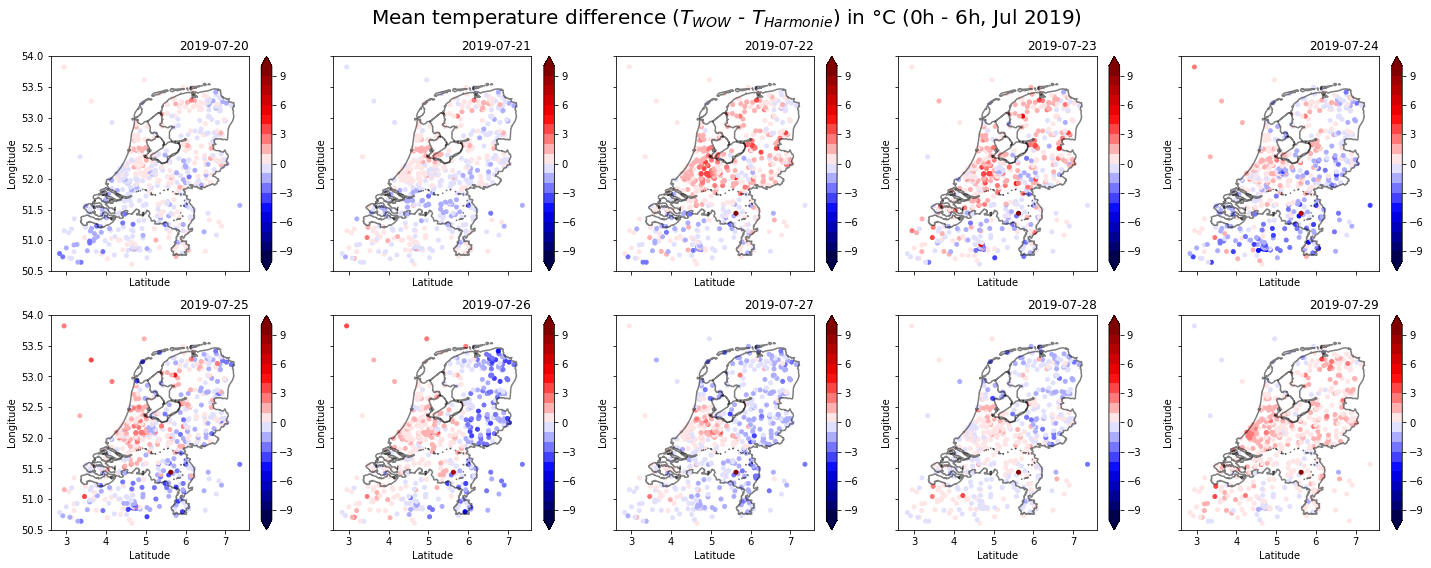

In [168]:

df_selected = df_merged.between_time('00:00', '06:00')
df_grouped = df_selected.groupby(pd.Grouper(key="datetime", freq="D"))

# Prepare plot
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20, 8), sharex=True, sharey=True)
# fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20, 8),subplot_kw={'projection': ccrs.PlateCarree()})
plt.suptitle("Mean temperature difference $(T_{WOW}$ - $T_{Harmonie})$ in °C (0h - 6h, Jul 2019)", size=20)
plt.subplots_adjust(hspace=0.5, wspace=0.5)

# fig.text(0.5, 0.04, 'Harmonie\'s deterministic forecast', ha='center')

rows = range(0, 2)
cols = range(0, 5)
pairs = list(itertools.product(rows, cols))

i = 0
for name, group in df_grouped:
    if i == 10:
        break
    
    group_group = group.groupby(['latitude','longitude'])
    data_wow = group_group.mean()["mean"]
    data_har = group_group.mean()["t2m_c"]
    bias = data_wow - data_har
    
    lat, lon = zip(*bias.index)
    
    
    r, c = pairs[i]
    ax[r, c].set_title(str(name).split(" ")[0], loc='right') #, fontweight="bold")
    ax[r, c].set_xlabel("Latitude")
    ax[r, c].set_ylabel("Longitude")
    r, c = pairs[i]
    p = ax[r, c].scatter(
        lon, lat, c=bias, s=16, 
        cmap=plt.cm.seismic,
        norm=colors.BoundaryNorm(boundaries=range(-10,11), ncolors=256),
    )
    cb = fig.colorbar(p, ax=ax[r,c],extend='both',shrink=1)
    
    gdf_NL.boundary.plot(ax=ax[r, c], alpha=0.5, edgecolor='k',aspect=None)
    
   
    i += 1 
    
plt.tight_layout()
plt.ylim(50.5,54)

# plt.savefig('./figures_diego/harm_wow_night_diff_map.png')
plt.show()




In [120]:
def plot_harm_ds_simple(harm_ds,date):
    date = pd.to_datetime(date).strftime('%Y-%m-%d') # just in case
    date_slice = slice(date,date)
    print(date_slice)
    harm_ds_sel = harm_ds.sel(valid_time=date_slice)

    # bin_aux = pd.date_range(start=start_datetime,end=end_datetime+np.timedelta64(2,'h'),freq='6h')
    bin_aux = pd.date_range(
        start=harm_ds_sel.valid_time.min().values,
        end=harm_ds_sel.valid_time.max().values+np.timedelta64(2,'h'),freq='6h')

    DS_aux = harm_ds_sel.t2m_k.groupby_bins('valid_time',bins=bin_aux).mean()-273.15


    # cbar_kwargs = {'label':'Temperature [degC]','shrink':1}
    cbar_kwargs = {'shrink':1}
    # subplot_kws={'projection': ccrs.PlateCarree()}

    p = DS_aux.plot.pcolormesh(
        x="longitude", 
        y="latitude", 
        col='valid_time_bins',
        col_wrap=2, 
        robust=True,
        size = 4,
        aspect=1.2,
        vmin = 0,
        vmax = 40,
        levels=41,
        cmap=plt.cm.gist_ncar,
        cbar_kwargs=cbar_kwargs,
    )
    plt.xlim(2,8)
    plt.ylim(50.5,54)

    p.cbar.set_label(label='Temperature (°C)', size=14)

    for idx, ax in enumerate(p.axes.flatten()):
        ax.set_title(str(bin_aux[idx]) + ' - ' + bin_aux[idx+1].strftime('%H:%M:%S'),fontsize=14)
        gdf_NL.boundary.plot(ax=ax, alpha=1, edgecolor='k',linewidth=1,aspect=None)
    
    fig = plt.gcf()
    fig.set_facecolor('w')
    fig.set_alpha(1)
    
    # plt.show()

slice('2019-07-22', '2019-07-22', None)


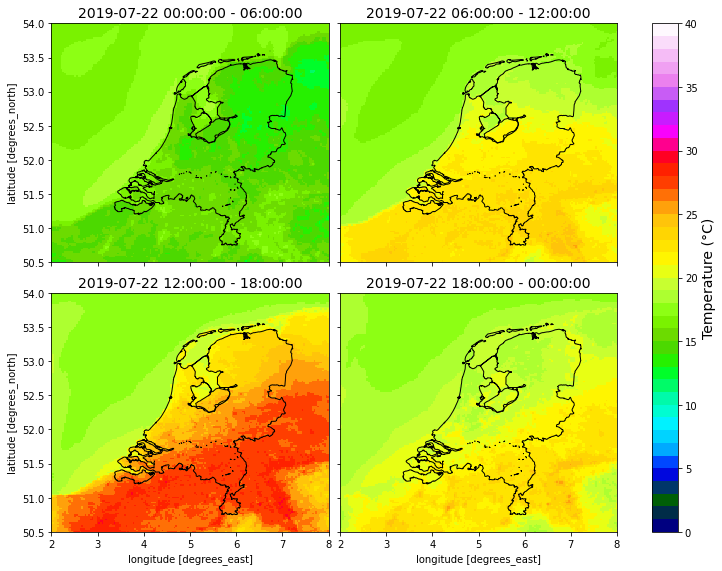

slice('2019-07-25', '2019-07-25', None)


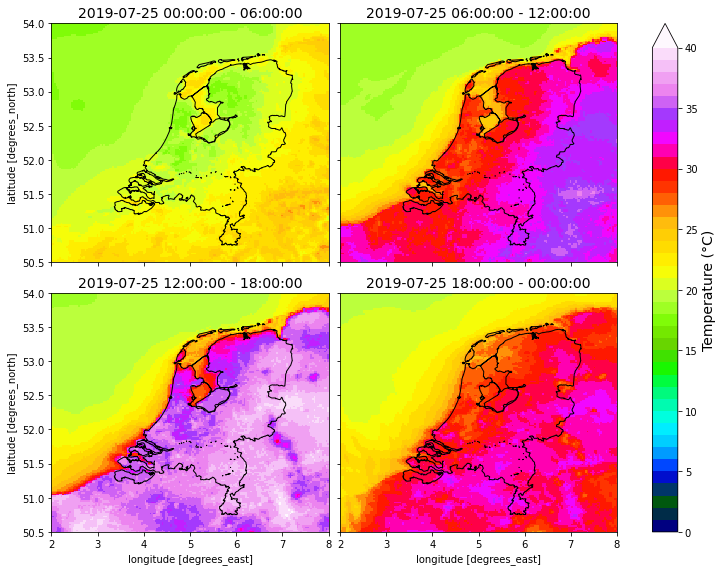

In [121]:
plot_harm_ds_simple(harm_ds,'2019-07-22')
plt.show()
plot_harm_ds_simple(harm_ds,'2019-07-25')
plt.show()
plt.savefig('./figures_diego/heatwave_4_25.png')

In [175]:
import gif
from IPython import display

# Decorate a plot function with @gif.frame (return not required):
@gif.frame
def plot_aux(harm_ds,date):
    plot_harm_ds_simple(harm_ds,date)

frames = []
# for date in time_range_days[:-1]:
for date in time_range_days[2:8]:
    frame = plot_aux(harm_ds,date)
    frames.append(frame)


gif.save(frames, './figures_diego/harmonie_heatwave_1.gif', duration=500)
del frames
plt.close('all')

slice('2019-07-22', '2019-07-22', None)
slice('2019-07-23', '2019-07-23', None)
slice('2019-07-24', '2019-07-24', None)
slice('2019-07-25', '2019-07-25', None)
slice('2019-07-26', '2019-07-26', None)
slice('2019-07-27', '2019-07-27', None)


In [230]:
# display.Image('./figures_diego/harmonie_heatwave_1.gif')
display.HTML('<img src="./figures_diego/harmonie_heatwave_1.gif">') # seems to take less 'memory' in the page notebook?


In [529]:
def plot_harm_wow_datetime_delta(harm_ds,datetime_in,min_to_agg = 0.9,dpi=60): # closed interval!!!

    datetime_in = pd.to_datetime(datetime_in) # just in case
    date_slice = slice(datetime_in,datetime_in+np.timedelta64(min_to_agg,'m'))
    print(date_slice)
    harm_ds_sel = harm_ds.sel(valid_time=date_slice)
    harm_ds_sel


    # Set figure size, projection, and extent.
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 7),subplot_kw={'projection': ccrs.PlateCarree()},dpi=dpi)
    for axi in ax:
        # ax.set_extent([loni_reg, lonf_reg, lati_reg, latf_reg]) 
        axi.set_extent([2, 8, 50.5, 54]) 

        # gdf_NL.boundary.plot(ax=axi, alpha=1, edgecolor='k',linewidth=1,aspect=None)
        gdf_NL.boundary.plot(ax=axi, alpha=1, edgecolor='k',linewidth=1)

        # plt.subplots_adjust(hspace=0.5, wspace=0.5)

        # Add coastlines and formatted gridlines.
        axi.coastlines(resolution="50m", linewidth=1)
        gl = axi.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color="black", linestyle="--")
        gl.top_labels = False
        gl.right_labels = False
        gl.xlines = True

    # Draw the plot.
    DS = harm_ds_sel.t2m_k.mean(dim='valid_time')-273.15
    p = DS.plot.pcolormesh(
        ax=ax[0],vmin=0,vmax=40,levels=41,cmap=plt.cm.gist_ncar,
        add_colorbar=False,
        add_labels=False,

    )

    # Adjustments.
    ax[0].set_title('HARMONIE: ' + str(harm_ds_sel.valid_time.min().values)[0:19] + ' - ' + str(harm_ds_sel.valid_time.max().values)[11:19], size=14)
    cb = plt.colorbar(mappable=p, ax=ax[0], orientation="horizontal", pad=0.04, shrink=1)
    cb.set_label(label='Temperature (°C)', size=14)
    cb.ax.tick_params(labelsize=8)

    # # gdf_NL.boundary.plot(ax=ax[0], alpha=1, edgecolor='k',linewidth=1,aspect=None)
    # gdf_NL.boundary.plot(ax=ax[0], alpha=1, edgecolor='k',linewidth=1)


    ##---------------------------------------------

    # df_selected = df_merged.between_time()
    df_selected = df_merged[date_slice]
    # df_grouped = df_selected.groupby(pd.Grouper(key="datetime", freq="H"))
    # df_grouped = df_selected

    group = df_selected
    group_group = group.groupby(['latitude','longitude'])
    data_wow = group_group.mean()["mean"]
    data_har = group_group.mean()["t2m_c"]
    bias = data_wow - data_har

    lat, lon = zip(*bias.index)


    p = ax[1].scatter(
        lon, lat, c=data_wow, s=16, 
        cmap=plt.cm.gist_ncar,
        norm=colors.BoundaryNorm(boundaries=range(0,41), ncolors=256),
    )

    # Adjustments.
    ax[1].set_title('WoW: ' + str(harm_ds_sel.valid_time.min().values)[0:19] + ' - ' + str(harm_ds_sel.valid_time.max().values)[11:19], size=14)
    cb = fig.colorbar(p, ax=ax[1],shrink=1,orientation="horizontal", pad=0.04)
    cb.set_label(label='Temperature (°C)', size=14)
    cb.ax.tick_params(labelsize=8)

    ##---------------------------------------------

    p = ax[2].scatter(
        lon, lat, c=bias, s=16, 
        cmap=plt.cm.seismic,
        norm=colors.BoundaryNorm(boundaries=range(-10,11), ncolors=256),
    )

    # Adjustments.
    ax[2].set_title('WoW - HARMONIE: ' + str(harm_ds_sel.valid_time.min().values)[0:19] + ' - ' + str(harm_ds_sel.valid_time.max().values)[11:19], size=14)
    cb = fig.colorbar(p, ax=ax[2],shrink=1,orientation="horizontal", pad=0.04)
    cb.set_label(label="$T_{WOW}$ - $T_{Harmonie}$ (°C)", size=14)
    cb.ax.tick_params(labelsize=8)

    # # cond = ~data_wow.isna() & (group_group.mean()["IsWithin"] == 1)
    # cond = ~data_wow.isna()
    # x = np.array(lon)[cond]
    # y = np.array(lat)[cond]
    # z = data_wow.values[cond]

    # # ax[2].tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
    # ax[2].tricontourf(x, y, z, levels=14, cmap=scp.cmap,alpha=0.1)

    fig = plt.gcf()
    fig.set_facecolor('w')
    fig.set_alpha(1)
    
    plt.tight_layout()
    
    
    # return 






slice(Timestamp('2019-07-25 00:00:00'), Timestamp('2019-07-25 05:54:00'), None)


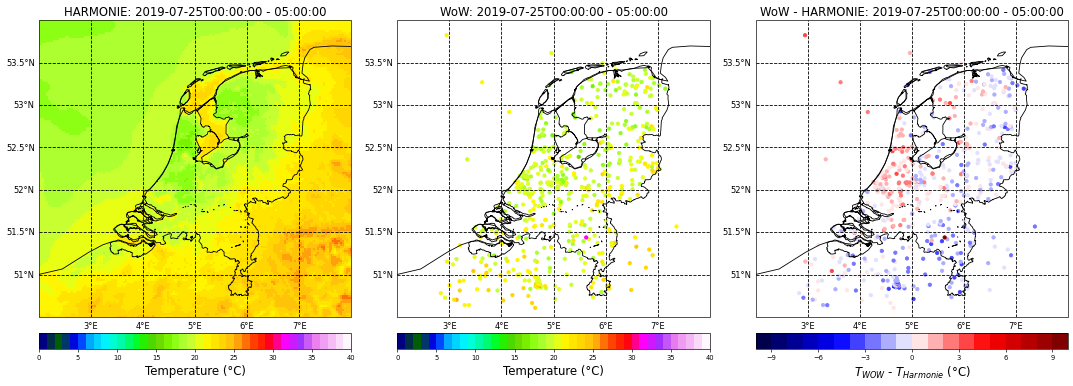

slice(Timestamp('2019-07-25 12:00:00'), Timestamp('2019-07-25 17:54:00'), None)


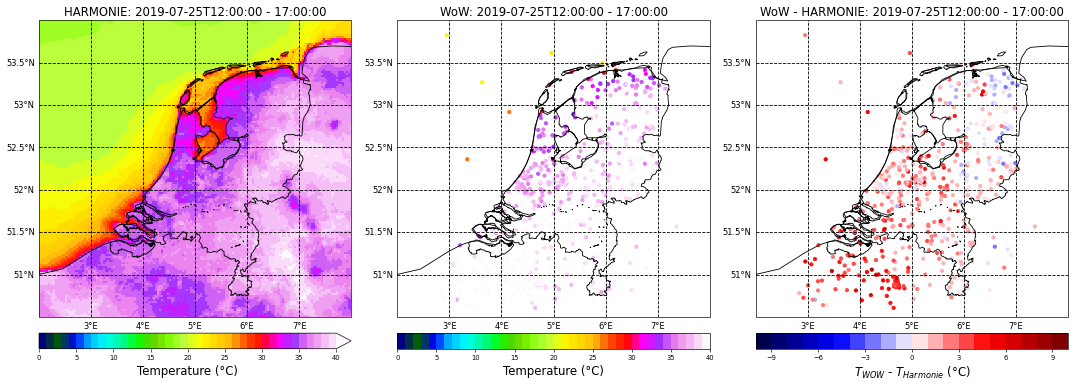

In [530]:
plot_harm_wow_datetime_delta(harm_ds,'2019-07-25T00:00:00',min_to_agg=6*59)
plt.show()
plot_harm_wow_datetime_delta(harm_ds,'2019-07-25T12:00:00',min_to_agg=6*59)
plt.show()
plt.close('all')

In [132]:
# for date in pd.date_range('2019-07-25T00:00:00',freq="6H",periods=4):
#     plot_harm_wow_datetime_delta(harm_ds,date,min_to_agg=6*59)
#     plt.show()

In [289]:
import gif
from IPython import display

# Decorate a plot function with @gif.frame (return not required):
@gif.frame
def plot_aux(harm_ds,datetime_in,min_to_agg = 0.9,dpi=60):
    plot_harm_wow_datetime_delta(harm_ds,datetime_in,min_to_agg,dpi)

frames = []
for date in pd.date_range('2019-07-25T00:00:00',freq="1H",periods=48):
    frame = plot_aux(harm_ds,date,min_to_agg=1*59,dpi=90)
    frames.append(frame)

gif.save(frames, './figures_diego/harmonie_heatwave_2_90dpi.gif', duration=175)
del frames
plt.close('all')

slice(Timestamp('2019-07-25 00:00:00', freq='H'), Timestamp('2019-07-25 00:59:00', freq='H'), None)
slice(Timestamp('2019-07-25 01:00:00', freq='H'), Timestamp('2019-07-25 01:59:00', freq='H'), None)
slice(Timestamp('2019-07-25 02:00:00', freq='H'), Timestamp('2019-07-25 02:59:00', freq='H'), None)
slice(Timestamp('2019-07-25 03:00:00', freq='H'), Timestamp('2019-07-25 03:59:00', freq='H'), None)
slice(Timestamp('2019-07-25 04:00:00', freq='H'), Timestamp('2019-07-25 04:59:00', freq='H'), None)
slice(Timestamp('2019-07-25 05:00:00', freq='H'), Timestamp('2019-07-25 05:59:00', freq='H'), None)
slice(Timestamp('2019-07-25 06:00:00', freq='H'), Timestamp('2019-07-25 06:59:00', freq='H'), None)
slice(Timestamp('2019-07-25 07:00:00', freq='H'), Timestamp('2019-07-25 07:59:00', freq='H'), None)
slice(Timestamp('2019-07-25 08:00:00', freq='H'), Timestamp('2019-07-25 08:59:00', freq='H'), None)
slice(Timestamp('2019-07-25 09:00:00', freq='H'), Timestamp('2019-07-25 09:59:00', freq='H'), None)


In [1]:
# display.Image('./figures_diego/harmonie_heatwave_2_90dpi.gif')
display.HTML('<img src="./figures_diego/harmonie_heatwave_2_90dpi.gif">')


AttributeError: 'function' object has no attribute 'HTML'

In [53]:
# # fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 10),subplot_kw={'projection': ccrs.PlateCarree()})
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 12))


# # cond = ~data_wow.isna() & (group_group.mean()["IsWithin"] == 1)
# cond = ~data_wow.isna()
# y = np.array(lat)[cond]
# z = data_wow.values[cond]

# scp = ax.scatter(x, y, c=z,cmap="RdBu_r",zorder=100)

# ax.tricontour(x, y, z, levels=14, linewidths=0.1, colors='k')
# ax.tricontourf(x, y, z, levels=14, cmap=scp.cmap,alpha=0.5)

# plt.subplots_adjust(hspace=0.5)
# plt.show()


In [301]:
# request = cimgt.OSM()
# request.crs

# fig = plt.figure(figsize=(18, 14))
# # Bounds: (lon_min, lon_max, lat_min, lat_max):
# # extent = [4.1, 4.9, 51.75, 52.2]
# extent = [4.0, 5.25, 51.7, 52.2]

# ax = plt.axes(projection=request.crs)
# ax.set_extent(extent)
# ax.add_image(request, 8)    # 5 = zoom level

# datetime_in) # just in casecb.ax.t
# del request

# plt.show()
# plt.close()

In [405]:
# request = cimgt.OSM()
# request.crs
# # request.crs.latitude_true_scale=50

# fig = plt.figure(figsize=(16, 14))
# # Bounds: (lon_min, lon_max, lat_min, lat_max):
# # extent = [4.1, 4.9, 51.75, 52.2]
# extent = [4.0, 5.25, 51.7, 52.2]

# ax = plt.axes(projection=request.crs)
# # ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent(extent)
# ax.add_image(request, 10)    # 5 = zoom level
# ax.grid()

# # Add coastlines and formatted gridlines.
# # ax.coastlines(resolution="50m", linewidth=1)
# gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color="black", linestyle="--")
# gl.top_labels = False
# gl.right_labels = False
# gl.xlines = True

# ####--------------------------

# datetime_in = pd.to_datetime('2019-07-25T12:00:00') # just in case
# date_slice = slice(datetime_in,datetime_in+np.timedelta64(6*59,'m'))
# print(date_slice)
# harm_ds_sel = harm_ds.sel(valid_time=date_slice)
# harm_ds_sel

# # df_selected = df_merged.between_time()
# df_selected = df_merged[date_slice]
# # df_grouped = df_selected.groupby(pd.Grouper(key="datetime", freq="H"))
# # df_grouped = df_selected

# group = df_selected
# group_group = group.groupby(['latitude','longitude'])
# data_wow = group_group.mean()["mean"]
# data_har = group_group.mean()["t2m_c"]
# bias = data_wow - data_har

# lat, lon = zip(*bias.index)


# # Draw the plot.
# # DS = harm_ds_sel.t2m_k.mean(dim='valid_time')-273.15
# # p = DS.plot.pcolormesh(
# #     ax=ax,vmin=0,vmax=40,levels=41,cmap=plt.cm.gist_ncar,
# #     add_colorbar=False,
# #     add_labels=False,
# #     transform=ccrs.PlateCarree(),
# #     alpha = 0.3,
# #     shading = ''
# # )

# DS = harm_ds_sel.t2m_k.mean(dim='valid_time')-273.15
# p = DS.plot.contour(
#     ax=ax,vmin=0,vmax=40,levels=100,cmap=plt.cm.gist_ncar,
#     add_colorbar=False,
#     add_labels=False,
#     transform=ccrs.PlateCarree(),
# )


# scp = ax.scatter(
#     lon, lat, c=data_wow, s=40, 
#     cmap=p.cmap,
#     edgecolor='k',
#     transform=ccrs.PlateCarree()
# )


# # cond = ~data_wow.isna() & (group_group.mean()["IsWithin"] == 1)
# cond = ~data_wow.isna()
# x = np.array(lon)[cond]
# y = np.array(lat)[cond]
# z = data_wow.values[cond]

# # # ax.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
# # ax.tricontourf(x, y, z, levels=14, cmap=scp.cmap,alpha=0.5,transform=ccrs.PlateCarree())


# # Adjustments.
# # ax.set_title('WoW: ' + str(harm_ds_sel.valid_time.min().values)[0:19] + ' - ' + str(harm_ds_sel.valid_time.max().values)[11:19], size=14)
# cb = fig.colorbar(mappable=p, ax=ax,shrink=0.45,orientation="vertical", pad=0.04)
# cb.set_label(label='Temperature (°C)', size=14)
# cb.ax.tick_params(labelsize=8)



# # del request

# plt.show()
# plt.close()

slice(Timestamp('2019-07-25 12:00:00'), Timestamp('2019-07-25 18:00:00'), None)


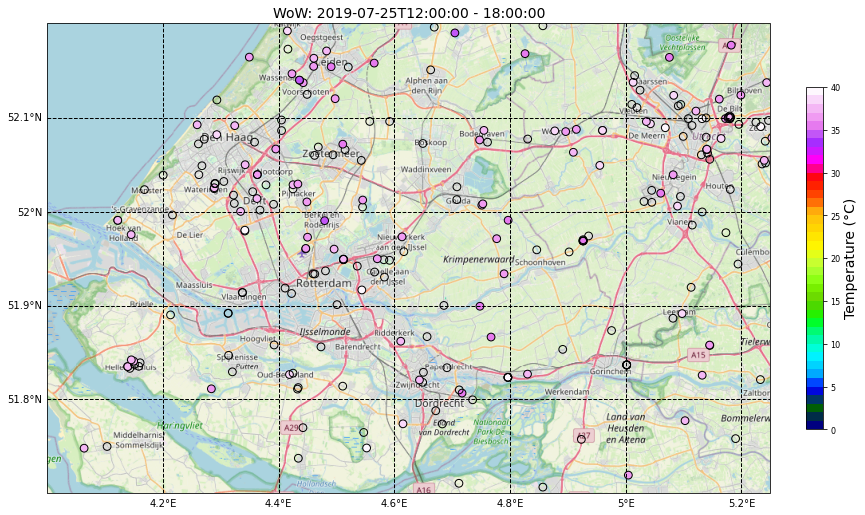

In [ ]:
request = cimgt.OSM()
request.crs
# request.crs.latitude_true_scale=50

fig = plt.figure(figsize=(16, 14))
# Bounds: (lon_min, lon_max, lat_min, lat_max):
# extent = [4.1, 4.9, 51.75, 52.2]
extent = [4.0, 5.25, 51.7, 52.2]

ax = plt.axes(projection=request.crs)
# ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent)
ax.add_image(request, 10)    # 5 = zoom level
ax.grid()

# Add coastlines and formatted gridlines.
# ax.coastlines(resolution="50m", linewidth=1)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color="black", linestyle="--")
gl.top_labels = False
gl.right_labels = False
gl.xlines = True

####--------------------------

datetime_in = pd.to_datetime('2019-07-25T12:00:00') # just in case
date_slice = slice(datetime_in,datetime_in+np.timedelta64(6*60,'m'))
print(date_slice)
harm_ds_sel = harm_ds.sel(valid_time=date_slice)
harm_ds_sel

# df_selected = df_merged.between_time()
df_selected = df_merged[date_slice]
# df_grouped = df_selected.groupby(pd.Grouper(key="datetime", freq="H"))
# df_grouped = df_selected

group = df_selected
group_group = group.groupby(['latitude','longitude'])
data_wow = group_group.mean()["mean"]
data_har = group_group.mean()["t2m_c"]
bias = data_wow - data_har

lat, lon = zip(*bias.index)


# Draw the plot.
# DS = harm_ds_sel.t2m_k.mean(dim='valid_time')-273.15
# p = DS.plot.pcolormesh(
#     ax=ax,vmin=0,vmax=40,levels=41,cmap=plt.cm.gist_ncar,
#     add_colorbar=true,
#     add_labels=False,
#     transform=ccrs.PlateCarree(),
#     alpha = 0.3,
#     shading = ''
# )


scp = ax.scatter(
    lon, lat, c=data_wow, s=60, 
    edgecolor='k',
    cmap=plt.cm.gist_ncar,
    norm=colors.BoundaryNorm(boundaries=range(0,41), ncolors=256),
    transform=ccrs.PlateCarree()
)


# cond = ~data_wow.isna() & (group_group.mean()["IsWithin"] == 1)
cond = ~data_wow.isna()
x = np.array(lon)[cond]
y = np.array(lat)[cond]
z = data_wow.values[cond]



# ax.tricontourf(x, y, z, levels=30, cmap=scp.cmap,alpha=0.15,transform=ccrs.PlateCarree())


# Adjustments.
ax.set_title('WoW: ' + str(harm_ds_sel.valid_time.min().values)[0:19] + ' - ' + str(harm_ds_sel.valid_time.max().values)[11:19], size=14)
cb = fig.colorbar(mappable=scp, ax=ax,shrink=0.45,orientation="vertical", pad=0.04)
cb.set_label(label='Temperature (°C)', size=14)
cb.ax.tick_params(labelsize=8)

plt.savefig('./figures_diego/urban_and_rural.png')

# del request

plt.show()
plt.close()

In [521]:
# # df_box = df_merged.query(f"(longitude > 4.8) & (longitude < 5.2) & (latitude > 51.8) & (latitude < 52.2)")
# box_cabauw = [4.7,5.1,51.8,52.2]
# df_box_cabauw = df_merged.query(f"(longitude > {box_cabauw[0]}) & (longitude < {box_cabauw[1]}) & (latitude > {box_cabauw[2]}) & (latitude < {box_cabauw[3]})")[['datetime','mean','t2m_c']]
# box_south = [4,6,50,52]
# df_box_south = df_merged.query(f"(longitude > {box_south[0]}) & (longitude < {box_south[1]}) & (latitude > {box_south[2]}) & (latitude < {box_south[3]})")[['datetime','mean','t2m_c']]
# box_north = [4,6,52,54]
# df_box_north = df_merged.query(f"(longitude > {box_north[0]}) & (longitude < {box_north[1]}) & (latitude > {box_north[2]}) & (latitude < {box_north[3]})")[['datetime','mean','t2m_c']]

# # df_box = df_merged.query(f"(longitude > 4) & (longitude < 6)  & (latitude > 50)")
# # df_box = df_merged.query(f"(longitude > 4) & (longitude < 6) & (latitude > 50) & (latitude < 52)")
# # df_box = df_merged.query(f"IsWithin")
# # df_group = df_box.rename(columns={'datetime':'datetime_col'}).groupby(['datetime_col'])

# df_group_cabauw = df_box_cabauw.rename(columns={'datetime':'datetime_col'}).groupby(['datetime_col'])
# df_group_south = df_box_south.rename(columns={'datetime':'datetime_col'}).groupby(['datetime_col'])
# df_group_north = df_box_north.rename(columns={'datetime':'datetime_col'}).groupby(['datetime_col'])

In [520]:
# plt.figure(figsize=(10,6))

# # df_group_south.mean()['mean'].plot(color='b',label='wow')
# # df_group_south.mean()['t2m_c'].plot(linestyle='--',color='b',label='Harm')

# df_group_cabauw.mean()['mean'].plot(color='g',label='wow')
# df_group_cabauw.mean()['t2m_c'].plot(linestyle='--',color='g',label='Harm')

# # df_group_north.mean()['mean'].plot(color='r',label='wow')
# # df_group_north.mean()['t2m_c'].plot(linestyle='--',color='r',label='Harm')

# # df_group_north.mean()['mean'].plot(label='WoW')
# # df_group_north.mean()['t2m_c'].plot()

# plt.ylabel('Temperature (degC)')
# plt.grid()
# plt.legend()


In [222]:
plt.close('all')

Text(0.5, 1.0, 'Temperature in the Netherlads')

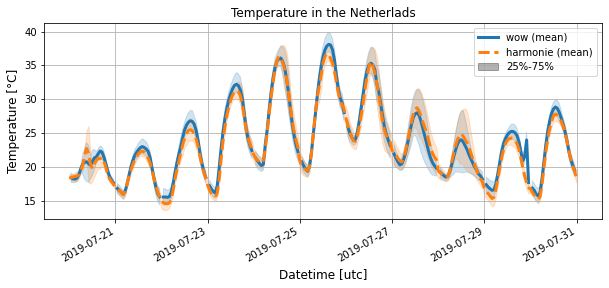

In [527]:
df_merged_within = df_merged[df_merged.IsWithin==1]

df_in = df_merged_within


plt.figure(figsize=(10,4))

stats_wow = df_in['mean'].groupby('datetime').describe()
stats_harm = df_in['t2m_c'].groupby('datetime').describe()

p = stats_wow['mean'].plot(label='wow (mean)',linewidth = 3)
plt.fill_between(stats_wow.index,stats_wow['25%'].values,stats_wow['75%'].values,color=p.lines[-1].get_color(),alpha=0.2)

stats_harm['mean'].plot(color='#ff7f0e',label='harmonie (mean)',linestyle='--',linewidth = 3)
plt.fill_between(stats_harm.index,stats_harm['25%'].values,stats_harm['75%'].values,color=p.lines[-1].get_color(),alpha=0.2)

plt.fill_between(stats_harm.index,np.nan*stats_harm['25%'].values,np.nan*stats_harm['25%'].values,
                 color=[0,0,0,0.3],label='25%-75%')



plt.ylabel('Temperature [°C]',fontsize=12)
plt.xlabel('Datetime [utc]',fontsize=12)
plt.grid()
plt.legend()
plt.title('Temperature in the Netherlads')

# plt.savefig('./figures_diego/heatwave_mean_temperature.png')
